In [49]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
np.set_printoptions(precision=2)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 2)

%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15

In [95]:
df = pd.read_csv('dream_table_beers_90447168_2017-01-17_11.22.45.csv')

In [96]:
df.head(n=20)

,User,Sim,Time,Index,User or Model?,Event,Item,Action,Laser on status,Wavelength,Width,Concentration,Absorption,Detector location,Ruler location,Table,X axis,Y axis,X axis scale,Y axis scale,Experiment #s included,Notes
0,90447168,beers-law-lab,0.00,0,model,initializing,sim,beersLawLab.sim.simStarted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90447168,beers-law-lab,0.00,2,model,updating state,NaN,NaN,False,780.0,1.00,0.1,NaN,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90447168,beers-law-lab,0.01,17,model,initializing,sim,beersLawLab.navigationBar.titleTextNode.textCh...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90447168,beers-law-lab,3.06,572,user,toggle laser,laser button,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90447168,beers-law-lab,3.08,574,model,updating state,NaN,NaN,True,780.0,1.00,0.1,0.96,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,90447168,beers-law-lab,5.54,1131,user,dragStarted,cuvetteNode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,90447168,beers-law-lab,5.59,1136,user,dragged,cuvetteNode,increasing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,90447168,beers-law-lab,5.59,1138,model,updating state,NaN,NaN,True,780.0,1.01,0.1,0.97,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,90447168,beers-law-lab,5.66,1145,user,dragged,cuvetteNode,increasing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,90447168,beers-law-lab,5.68,1148,user,dragged,cuvetteNode,increasing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
#list all the events and items to inform action to family dictionary
print df['Event'].unique()
print df['Item'].unique()

#create new family column and fill with NaN to test later to make sure every action has been converted to family
df["Family"] = np.nan

['initializing' 'updating state' 'toggle laser' 'dragStarted' 'dragged'
 'dragEnded' 'editing notes' 'recording data' 'expanding table'
 'expanding graph' 'Adding data to graph' 'Selecting Y-axis'
 'Selecting X-axis' 'Changed concentration' 'Removing data from table'
 'Selecting scale of Y-axis']
['sim' nan 'laser button' 'cuvetteNode' 'notepad' 'wavelengthControls'
 'solutionControls' 'detectorNode' 'table' 'graph' 'trialNumber 1'
 'Y-axis dropdown menu' 'X-axis dropdown menu' 'trialNumber 2'
 'trialNumber 3' 'concentration slider' 'trialNumber 4' 'trialNumber 5'
 'trialNumber 6' 'trialNumber 7' 'trialNumber 8' 'trialNumber 9'
 'trialNumber 20' 'trialNumber 19' 'trialNumber 18' 'trialNumber 17'
 'trialNumber 16' 'trialNumber 15' 'trialNumber 14' 'trialNumber 13'
 'trialNumber 12' 'trialNumber 11' 'trialNumber 10'
 'Y-axis scale dropdown menu']


In [107]:
# Define actions families
# I'm not sure what is 'Changed concentration' - is it using the arrows to change concentration?
action_to_family = {'Dr':['dragStarted','dragged','dragEnded'],
                   'N':['editing notes'],
                    'M':['recording data'],
                   'Dt':['expanding table', 'Removing data from table'],
                    'G':['expanding graph','Adding data to graph','Selecting Y-axis','Selecting X-axis', 'Selecting scale of Y-axis'],
                   'O':['initializing', 'toggle laser', 'Changed concentration'],
                   'St':['updating state']}

In [108]:
# Populate family column based on action_to_family dict above
# THERE IS FASTER WAY TO DO THIS....
for row in df.index:
    for family in action_to_family.keys():
        if df.loc[row,'Event'] in action_to_family[family]:
            df.loc[row,'Family'] = family  

In [109]:
# Test to make sure all events have a family
df['Event'][df['Family'].isnull()]

Series([], Name: Event, dtype: object)

In [139]:
def get_blocks_withTime(df, students, ignore=['St'], add_spaces=False):
    
    '''
    This function gets action sequences in block form along with time stamps for each block for plotting.
    '''
    blocks = {student:'' for student in students}
    time_coords = {student:[] for student in students}
    for student in students:
        sequence =  list(df['Family'])
#         print sequence
        time_stamps =  list(df['Time'])
        time_coord=[]  #coordinate array for broken bar plot, takes array of (start time, duration)
        p = re.compile(r'([A-Z][a-z]{0,3})\1*')  #this regex finds all action blocks of length 1+
#         print ''.join([action for action in sequence if action not in ignore])
        #print time_stamps
        ##use finditer to return a sequence of matches as an iterator
        previous_start = 0
        for match in p.finditer(''.join([action for action in sequence if action not in ignore])):
            ind = match.span()  #this gives start and end of matched block
            ##for matches of action denoted by more than 1 letter (e.g. Tb), need to correct the span
#             print match.group(), match.span(), ind[1]-ind[0], len(set(match.group())),
            ##set() function yields unique elements of a set, which allows picking out those actions with > 1 letter
            ##for e.g. if match.group() gives "CCCCC", then set() of that is "C" while for "TbTbTb" we'd have "T","b"
            ind = (previous_start, previous_start + (ind[1]-ind[0])/len(set(match.group())))
            #print ind
            previous_start = ind[1]
            if ind[1] >= len(time_stamps):  #block location offset from real index by 1
                duration = time_stamps[ind[1]-1] - time_stamps[ind[0]]  #time duration of block
                #print time_stamps[ind[1]-1], time_stamps[ind[0]]  #time duration of block
            else:
                duration = time_stamps[ind[1]] - time_stamps[ind[0]]
                #print time_stamps[ind[1]] , time_stamps[ind[0]]
            time_coord.append((time_stamps[ind[0]],duration))
            #print match.group(), match.span(), duration
        #actual regex that converts block of similar actions to just one action
        block = re.sub(r'([A-Z][a-z]{0,3})\1+', r'\1',''.join([action for action in sequence if action not in ignore]))
        if add_spaces:
            spaced_block = block[0]
            for b in block[1:]:
                spaced_block += ' '+b
            blocks[student] += spaced_block
            time_coords[student] = time_coord
        else:
            blocks[student] += block
            time_coords[student] = time_coord
    return blocks, time_coords
 

In [127]:
# color dict for plotting action timeline plots
color_pos =  {'Dr':('#31a354',1),
    'N':('#969696',2),
#     'Test_basic': ('#fb6a4a',3),
    'M': ('#a50f15',4),
    'Dt': ('#4a1486',5),
    'G':('#c51b8a',6),
    'O':('#c51b8a',6)
    }

In [183]:
def plot_barGraph_new(df, studentID, pltFamilies, axis_labels, ignore=['St']):
    '''
    This function plots timeline action plots
    '''
    #get blocks of actions and their time coordinate for broken bar plot
    blocks, time_coords = get_blocks_withTime(df, {studentID}, ignore)
    #create figure and axes
    fig, ax = plt.subplots()

    #need this to convert desired action families back to letter code
    def convert(action,ignore):
        return action
    
    #split sequences so that each block is an element of a list
    splitblocks = re.compile(r'([A-Z]{1}[a-z]{0,3})\1*').split(blocks[studentID])
    splitblocks = [s for s in splitblocks if s != ""]
#     print splitblocks
    #grab time coordinates of each blocks from dict 
    time_coord = time_coords[studentID]
    for action in pltFamilies: 
        nn = color_pos[action][1]
        #next 2 lines sample out relevant action blocks for one broken horizontal bar
        #print action
        #print (blocks[studentID])
        #print len(splitblocks), len(time_coord)
        if convert(action,[]) in splitblocks:
#             print convert(action,[])
#             print sum([1 for s in splitblocks if s ==convert(action,()) ])
            
            out = [(x,y) for x,y in zip(splitblocks,time_coord) if convert(action,[]) == x]
            try:
                _, time_coord_filtered = map(list,zip(*out))  
                ax.broken_barh(time_coord_filtered,(10*nn,9),facecolors=color_pos[action][0],linewidth=2,edgecolor='k')            
            except:
                print 'failed', action,convert(action,[])
#                 for x,y in zip(splitblocks,time_coord):
#                     print convert(action,[]), x,y, convert(action,[]) == x
                pass

                    
    ax.set_ylim(5, len(axis_labels)*10+15)
    ax.set_xlim(0, time_coord[-1][0]+time_coord[-1][1]+2)
    ax.set_xlabel('Time (s)', fontsize=25)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(15,len(axis_labels)*10+15,10))
    ax.set_yticklabels(axis_labels, fontsize=25)
    ax.grid(True)
    return None

In [184]:
pltFamilies = ['Dr','N','M','Dt','G','O']
axis_labels = ['Drag','Notes','Measure','Data Table','Graph','Other']

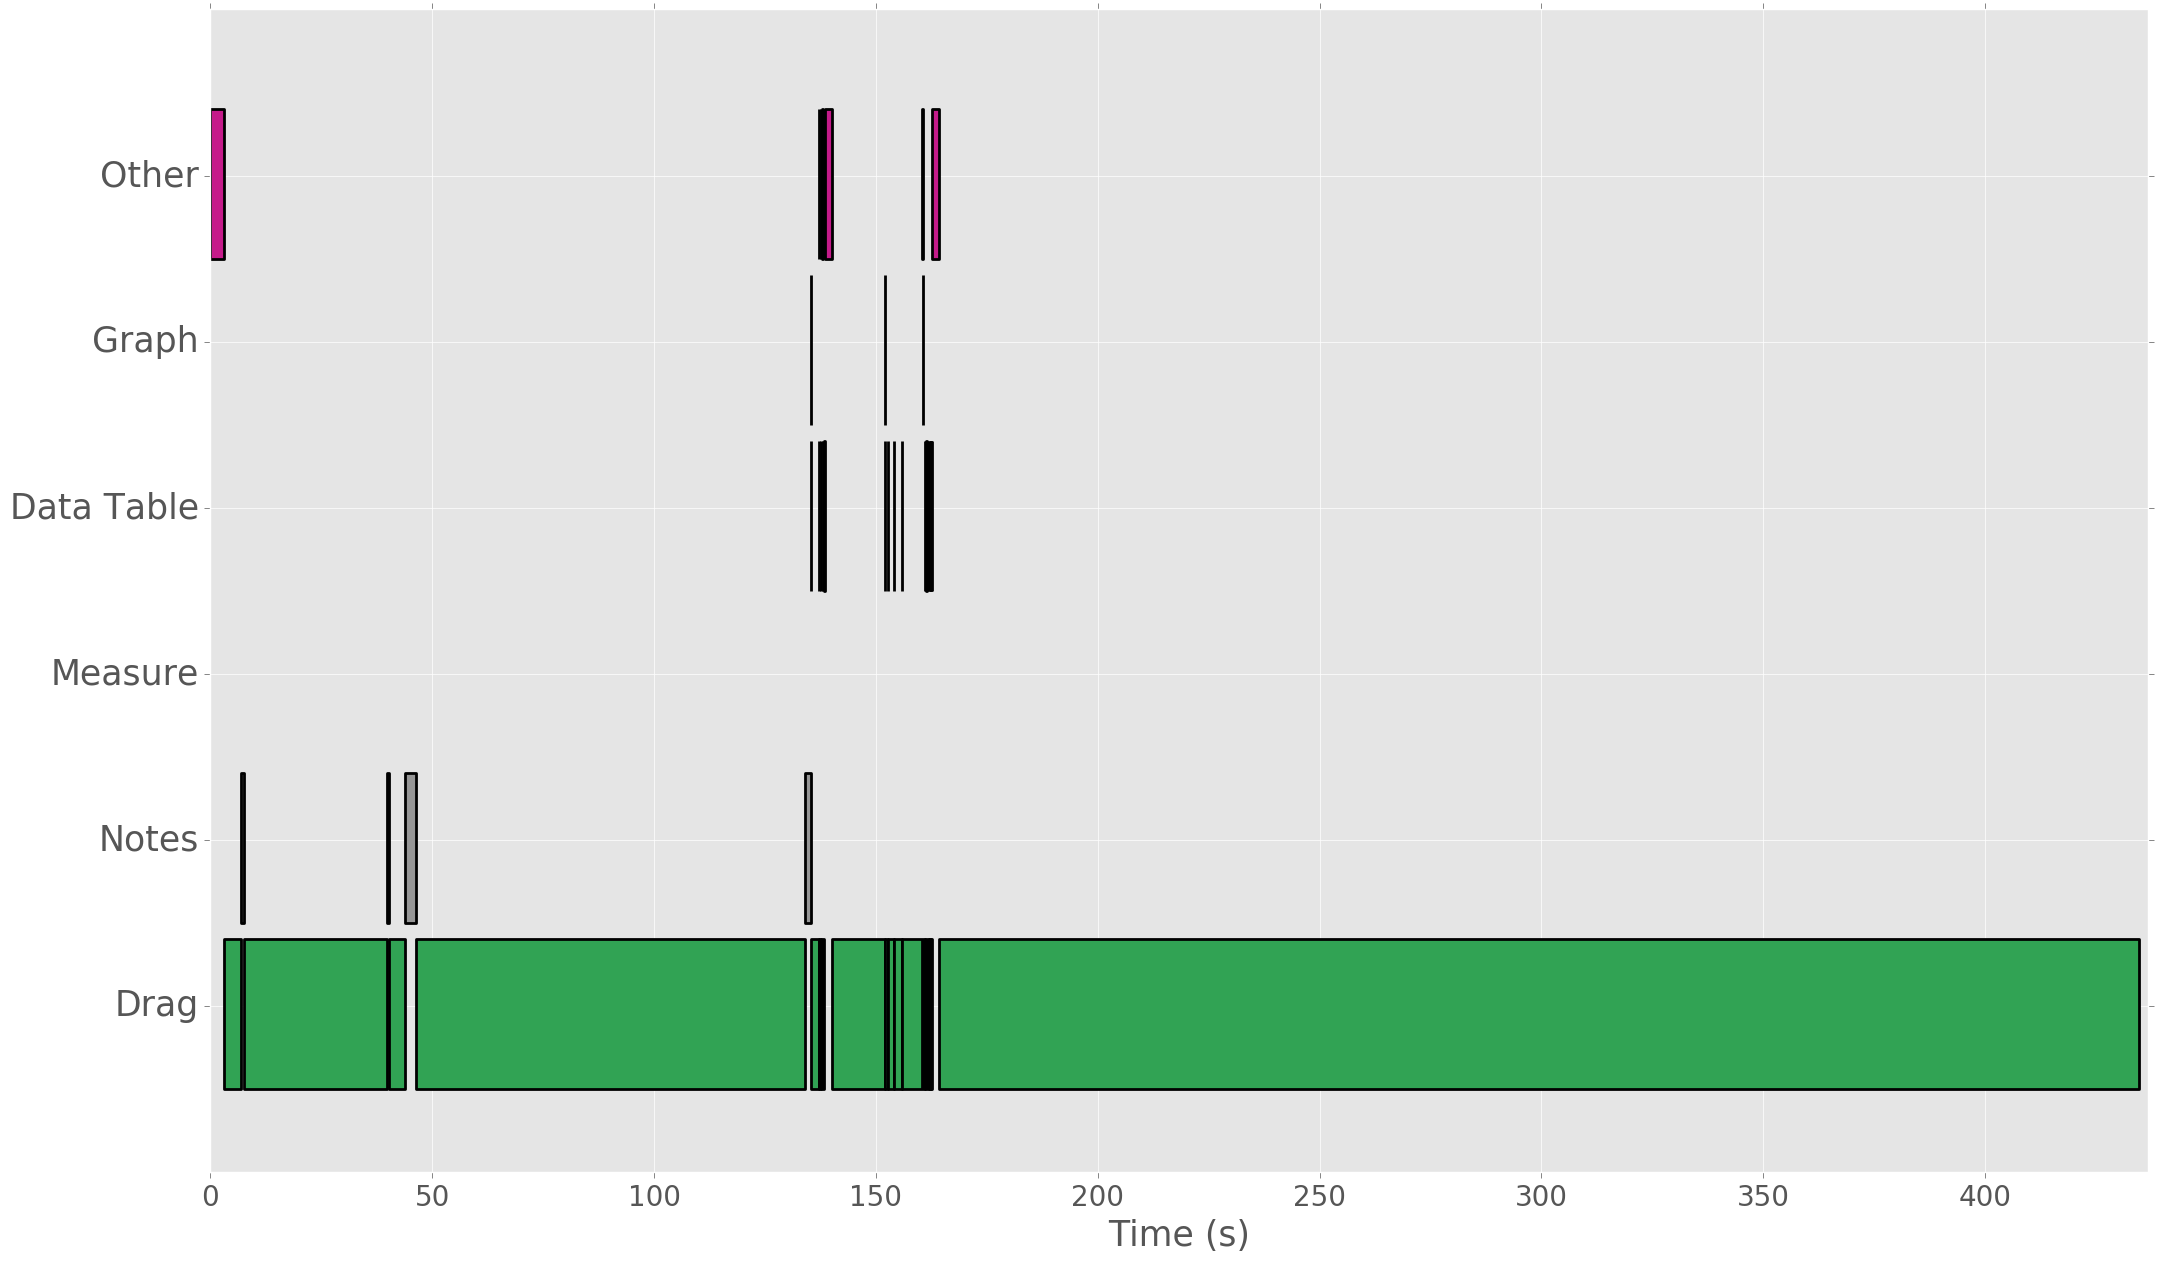

In [185]:
plot_barGraph_new(df, '123456789', pltFamilies, axis_labels)
#i made linewidth black and thick so we can see thin bars of some families